In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statistics import mean, stdev
import sys
import os
if "../" not in sys.path:
  sys.path.append("../") 
os.chdir("..") 
from envs.data_handler import DataHandler
import envs.data_utils as du

# function for plotting
def plot_data(data_table, type):
    lists = data_table.groupby(['Optimal_Affected_Component_Uid', 'Optimal_Failure'])[type].apply(list).values
    fig = plt.figure(figsize=(50, 5))
    for l in lists:
        plt.hist(l, 50, alpha=0.5)
    plt.show()

dh = DataHandler()
dh.data.head()

,Optimal_Affected_Component,Optimal_Affected_Component_Uid,Optimal_Failure,raw,cube,sqt,log10,ln,log2
0,Query Service,_SEwwu-cdEeet0YmmfbMwkw,CF1,49.5,2.924018,5.000000,1.39794,3.218876,4.643856
1,User Management Service,_SExXgOcdEeet0YmmfbMwkw,CF2,16.0,2.924018,5.000000,1.39794,3.218876,4.643856
2,Authentication Service,_SEx_HucdEeet0YmmfbMwkw,CF3,31.5,2.519842,4.000000,1.20412,2.772589,4.000000
3,Bid and Buy Service,_SEymDucdEeet0YmmfbMwkw,CF3,25.0,2.519842,4.000000,1.20412,2.772589,4.000000
4,Item Management Service,_SExYKucdEeet0YmmfbMwkw,CF3,16.0,2.000000,2.828427,0.90309,2.079442,3.000000


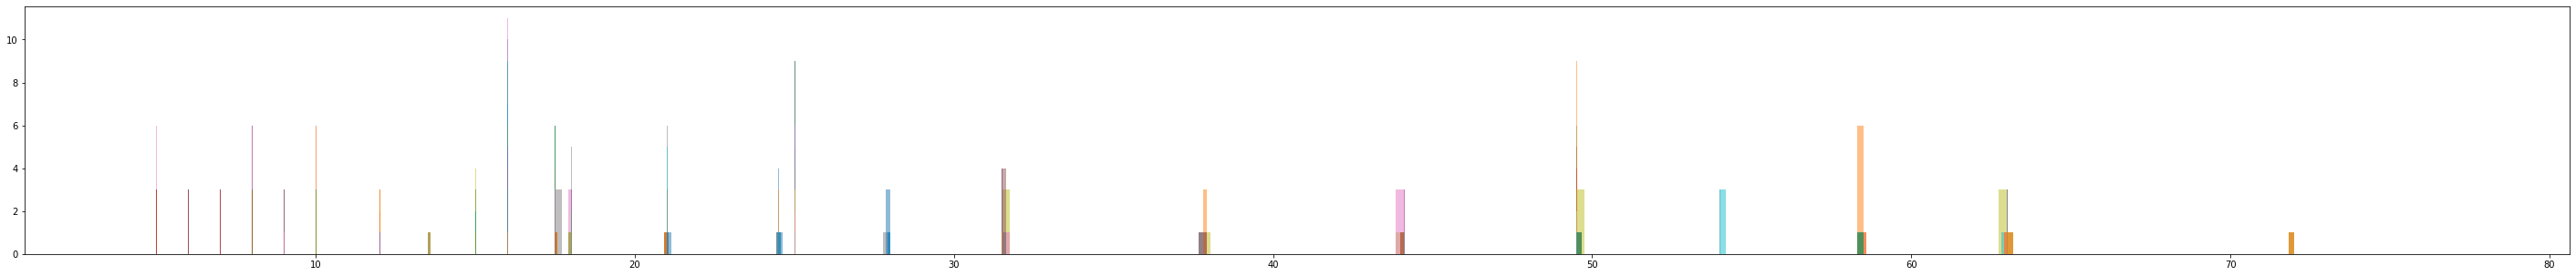

In [3]:
plot_data(dh.data, 'raw')

# Data Shift

## Step 1: Calculate the Standard Deviation and the mean of each <component, failure> combinations

In [4]:
mean_values = dh.data.groupby(['Optimal_Affected_Component_Uid', 'Optimal_Failure']).mean().reset_index()
stdev_values = dh.data.groupby(['Optimal_Affected_Component_Uid', 'Optimal_Failure']).std().reset_index().fillna(0)

## Step 2: Sort data by mean values 

In [5]:
mean_values = mean_values.sort_values(by=['raw'], ascending=True)

## Step 3: Iterate over data and shift it

In [6]:
data_new = dh.data.copy()

previous = None
for _, name in mean_values.iterrows():
    if previous is not None:
        pre_std = stdev_values.loc[(stdev_values['Optimal_Affected_Component_Uid'] == previous[0]) & (stdev_values['Optimal_Failure'] == previous[1])]['raw'].tolist()[0]
        cur_std = stdev_values.loc[(stdev_values['Optimal_Affected_Component_Uid'] == name[0]) & (stdev_values['Optimal_Failure'] == name[1])]['raw'].tolist()[0]
        data_new.loc[(data_new['Optimal_Affected_Component_Uid'] == name[0]) & (data_new['Optimal_Failure'] == name[1]), 'raw'] += cur_std + pre_std
    previous = name
    
data_new[['Optimal_Affected_Component','Optimal_Affected_Component_Uid', 'Optimal_Failure', 'raw']].head()

,Optimal_Affected_Component,Optimal_Affected_Component_Uid,Optimal_Failure,raw,cube,sqt,log10,ln,log2
0,Query Service,_SEwwu-cdEeet0YmmfbMwkw,CF1,60.295935,2.924018,5.000000,1.39794,3.218876,4.643856
1,User Management Service,_SExXgOcdEeet0YmmfbMwkw,CF2,16.000000,2.924018,5.000000,1.39794,3.218876,4.643856
2,Authentication Service,_SEx_HucdEeet0YmmfbMwkw,CF3,31.500000,2.519842,4.000000,1.20412,2.772589,4.000000
3,Bid and Buy Service,_SEymDucdEeet0YmmfbMwkw,CF3,25.000000,2.519842,4.000000,1.20412,2.772589,4.000000
4,Item Management Service,_SExYKucdEeet0YmmfbMwkw,CF3,16.000000,2.000000,2.828427,0.90309,2.079442,3.000000


## Step 4: Analyse

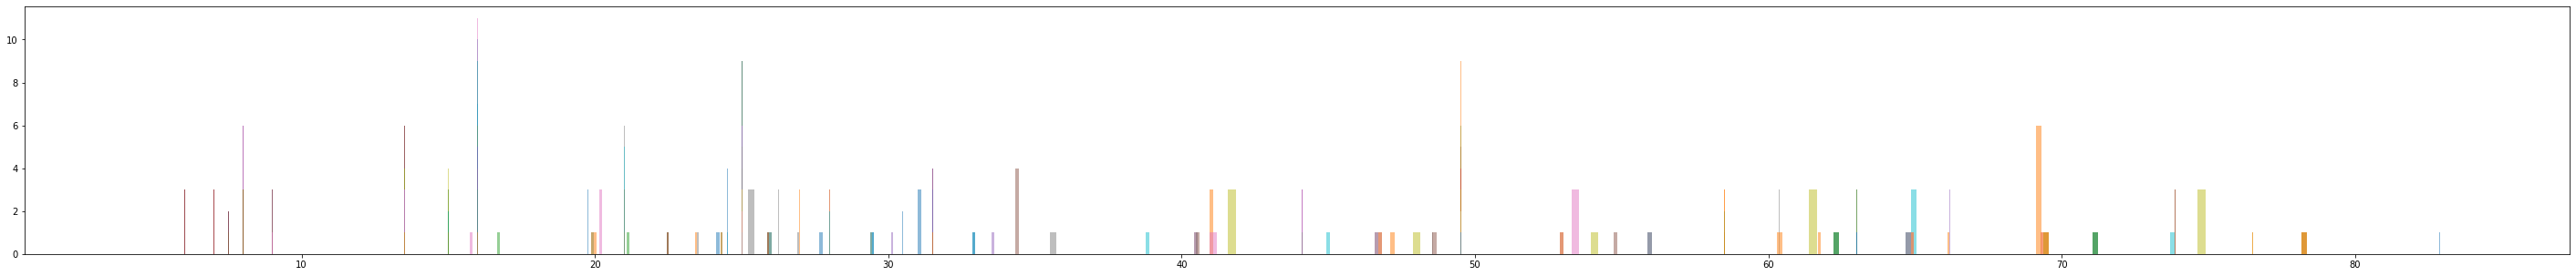

In [7]:
plot_data(data_new, 'raw')

## Step 5: Perform T-Test

In [8]:
result = du.perform_ttest(mean_values, data_new, 'raw')
print(len(result[result['pvalue']<0.025]), 'of the ', len(result.index) ,' <component, failure> combination pairs are statistical significant')

/Users/rachel/.local/share/virtualenvs/rl-4-self-repair-tzCb2l5a/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/rachel/.local/share/virtualenvs/rl-4-self-repair-tzCb2l5a/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


22 of the  914  <component, failure> combination pairs are statistical significant


# Experiment

First transform data and then shift it.

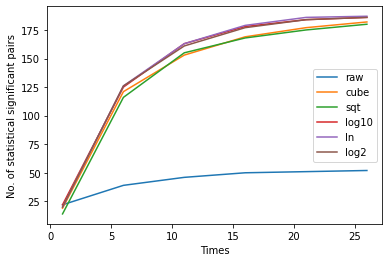

In [9]:
# <component, failure> = x + (prestd + curstd) * times
types = ['raw', 'cube', 'sqt', 'log10', 'ln', 'log2']
x_ticks = range(1,30, 5)

for t in types:
    results = []
    for i in x_ticks:
        (means, shifted_data) = du.shift_data(dh.data, t, times=i)
        ttest = du.perform_ttest(means, shifted_data, t)
        r = len(ttest[ttest['pvalue']<0.025])
        results.append(r)
    plt.plot(x_ticks, results, label=t)

plt.xlabel("Times")
plt.ylabel("No. of statistical significant pairs")
plt.legend()
plt.show()

Evaluating the best number of times for shifting:

raw 22 51 50
raw 23 51 50
raw 24 52 49
raw 25 52 50
raw 26 52 49
raw 27 52 48
raw 28 52 47
raw 29 52 46
raw 30 52 45
raw 31 52 44
raw 32 52 43
raw 33 52 42
raw 34 52 41
raw 35 52 40
raw 36 52 39
raw 37 52 38
raw 38 52 37
raw 39 52 36
raw 40 52 35
raw 41 52 34
raw 42 52 33
raw 43 52 32
raw 44 52 31
raw 45 52 30
raw 46 52 29
raw 47 52 28
raw 48 52 27
raw 49 52 26
raw 50 52 25
raw 51 52 24
raw 52 52 23
raw 53 52 22
raw 54 52 21
raw 55 52 20
raw 56 52 19
raw 57 52 18
raw 58 52 17
raw 59 52 16
raw 60 52 15
raw 61 52 14
raw 62 52 13
raw 63 52 12
raw 64 52 11
raw 65 52 10
raw 66 52 9
raw 67 52 8
raw 68 52 7
raw 69 52 6
raw 70 52 5
raw 71 52 4
raw 72 52 3
raw 73 52 2
raw 74 52 1
cube 22 178 50
cube 23 179 50
cube 24 179 50
cube 25 180 49
cube 26 182 50
cube 27 184 50
cube 28 186 50
cube 29 186 50
cube 30 186 49
cube 31 186 48
cube 32 186 47
cube 33 188 46
cube 34 189 50
cube 35 189 50
cube 36 189 49
cube 37 189 48
cube 38 189 47
cube 39 190 46
cube 40 190 50
cube 41 190 49
cube 42 191 48
cube 

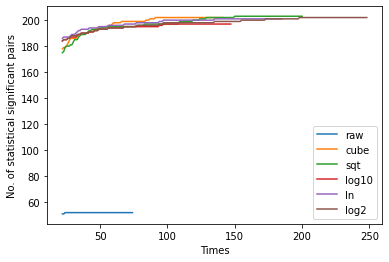

In [25]:
result = {}
times = range(22, 914, 1)

for t in types:
    x = []
    values = []
    stop = 50
    if t not in result:
        result[t] = (0,0) # (times, number of statistical significant) 
    for i in times:
        if stop != 0:
            (means, shifted_data) = du.shift_data(dh.data, t, times=i)
            ttest = du.perform_ttest(means, shifted_data, t)
            r = len(ttest[ttest['pvalue']<0.025])
            values.append(r)
            x.append(i)
            print(t, i, r, stop)
            if r > result[t][1]:
                result[t] = (i, r)
                stop = 50
            else:
                stop -= 1
        else:
            break
    plt.plot(x, values, label=t)

print(result)
plt.xlabel("Times")
plt.ylabel("No. of statistical significant pairs")
plt.legend()
plt.savefig('line_plot.pdf') 
plt.show()

And then saving optimal shifted data to csv

In [3]:
result = {'raw': (24, 52), 'cube': (91, 202), 'sqt': (150, 203), 'log10': (97, 197), 'ln': (135, 201), 'log2': (198, 202)}
optimal_shifted_data = dh.data

for t, value in result.items():
    (_, optimal_shifted_data) = du.shift_data(optimal_shifted_data, t, times=value[0])
    
optimal_shifted_data.to_csv('prepared_data_Linear_Shifted.csv')
print("Data saved.")

Data saved.
